In [1]:
import os
import pandas as pd
import pydicom
import cv2
import numpy as np
import csv
import random

In [2]:
tampered_data_path = r"/mnt/c/Users/jones/OneDrive/Desktop/VS_Code/STA221/Data/tampered_slices"
untampered_data_path = r"/mnt/c/Users/jones/OneDrive/Desktop/VS_Code/STA221/Data/untampered_slices"

# Getting Slices For Tampered Data

In [3]:
image_size = (256, 256)

# Helper function to process and normalize the image
def process_image(dcm_file):
    pixel_array = dcm_file.pixel_array
    pixel_array = cv2.resize(pixel_array, image_size)
    pixel_array = cv2.normalize(pixel_array, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    return pixel_array

In [4]:
def load_slices(tampered_data_path):
    slices = []
    paths = os.listdir(tampered_data_path)

    for path in paths:
        if path.endswith(".dcm"):
            dcm_path = os.path.join(tampered_data_path, path)
            dcm = pydicom.dcmread(dcm_path)
            pixel_array = process_image(dcm)
            slices.append(pixel_array)
    return np.asarray(slices)

In [5]:
tampered_slices = load_slices(tampered_data_path)
tampered_slices.shape

(1140, 256, 256)

In [6]:
untampered_slices = load_slices(untampered_data_path)
untampered_slices.shape

(1140, 256, 256)

In [7]:
from sklearn.model_selection import train_test_split

# Provided code
untampered_labels = np.zeros(len(untampered_slices))  # 0 = 'untampered'
tampered_labels = np.ones(len(tampered_slices))     # 1 = 'tampered'

print(tampered_slices.shape)
print(untampered_slices.shape)

X_all = np.vstack((untampered_slices, tampered_slices))
y_all = np.hstack((untampered_labels, tampered_labels))

X_all = X_all.reshape(X_all.shape[0], -1)  # Flatten each image to a 1D vector

print(X_all.shape)
print(y_all.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

print(np.min(X_test), np.max(X_test))

# Print the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


(1140, 256, 256)
(1140, 256, 256)
(2280, 65536)
(2280,)
0 65535
X_train shape: (1824, 65536)
X_test shape: (456, 65536)
y_train shape: (1824,)
y_test shape: (456,)


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test):
    # Get predictions from the model
    y_pred = model.predict(X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap=plt.cm.Blues, values_format='d')

    # Customize the plot
    plt.title("Confusion Matrix")
    plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(model, X_test, y_test):
    # Get predicted probabilities (for the positive class)
    y_prob = model.predict_proba(X_test)[:, 1]  # for binary classification, [1] for positive class

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Compute AUC
    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {auc:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Random classifier line
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import copy

def train_model_with_cross_validation(model, X_train, y_train, n_splits=5):
    # Initialize cross-validation strategy
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Metrics storage
    metrics = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    best_model = None
    best_accuracy = 0

    # Perform cross-validation
    for train_index, test_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        # Train the model
        model.fit(X_fold_train, y_fold_train)

        # Predict on the test set
        y_pred = model.predict(X_fold_test)

        # Compute metrics
        metrics["accuracy"].append(accuracy_score(y_fold_test, y_pred))
        metrics["precision"].append(precision_score(y_fold_test, y_pred, zero_division=0))
        metrics["recall"].append(recall_score(y_fold_test, y_pred, zero_division=0))
        metrics["f1_score"].append(f1_score(y_fold_test, y_pred, zero_division=0))

        print("Fold accuracy:", metrics["accuracy"][-1])

        if metrics["accuracy"][-1] > best_accuracy:
            best_accuracy = metrics["accuracy"][-1]
            best_model = copy.deepcopy(model)

    # Compute average metrics
    avg_metrics = {metric: np.mean(scores) for metric, scores in metrics.items()}

    return avg_metrics, best_model

# Logistic Regression

Fold accuracy: 0.8547945205479452
Fold accuracy: 0.8657534246575342
Fold accuracy: 0.9013698630136986
Fold accuracy: 0.8904109589041096
Fold accuracy: 0.8543956043956044
{'accuracy': np.float64(0.8733448743037784), 'precision': np.float64(0.9174213106114791), 'recall': np.float64(0.8224518888096934), 'f1_score': np.float64(0.867074065216712)}
Test Accuracy: 0.9123


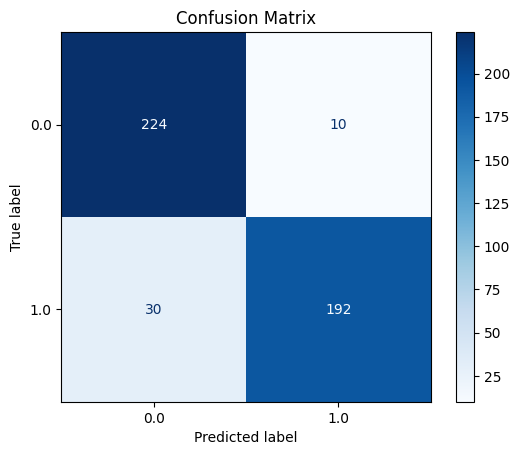

AUC: 0.9078


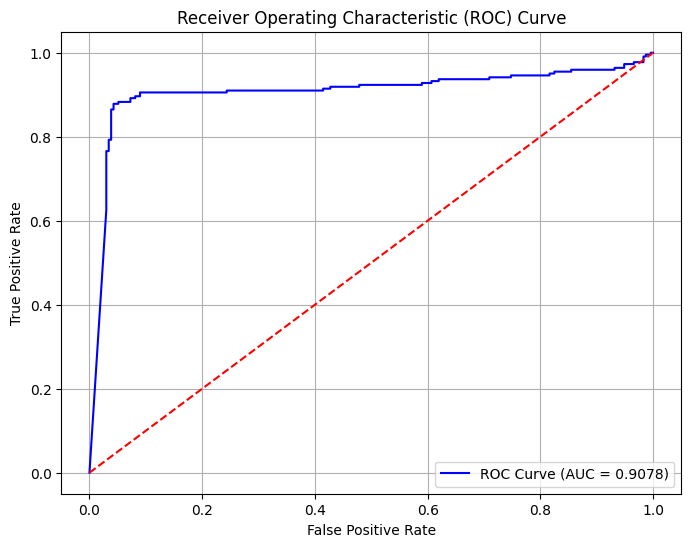

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
results, best_model = train_model_with_cross_validation(model, X_train, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test, y_test)
plot_roc_curve(best_model, X_test, y_test)

# Random Forest

Fold accuracy: 0.4547945205479452
Fold accuracy: 0.4602739726027397
Fold accuracy: 0.4684931506849315
Fold accuracy: 0.4547945205479452
Fold accuracy: 0.4697802197802198
{'accuracy': np.float64(0.4616272768327563), 'precision': np.float64(0.3361348979338036), 'recall': np.float64(0.0718935614160133), 'f1_score': np.float64(0.11827169172246854)}
Test Accuracy: 0.4890


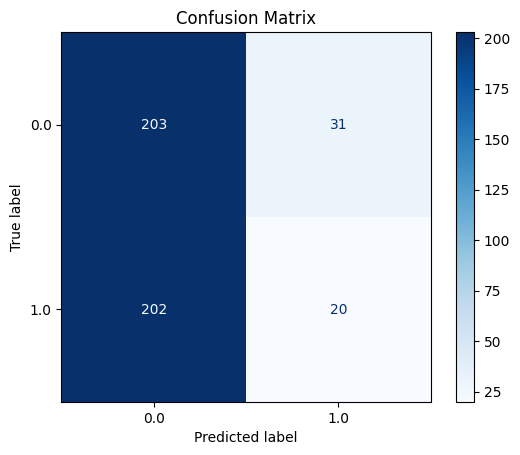

AUC: 0.5648


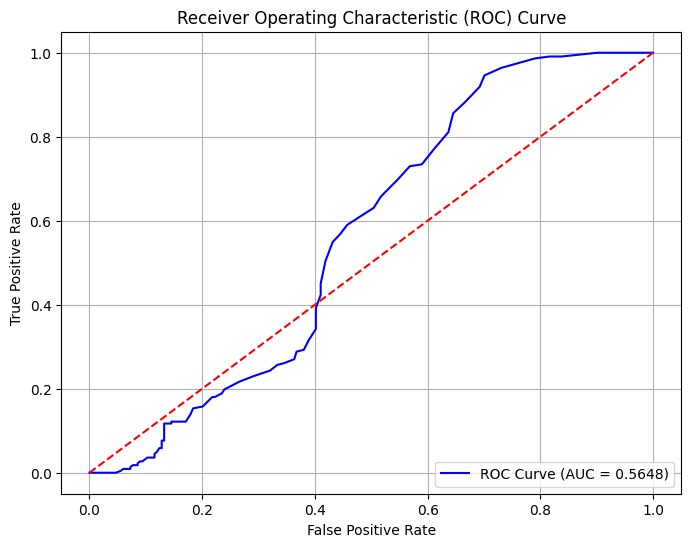

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

results, best_model = train_model_with_cross_validation(model, X_train, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test, y_test)
plot_roc_curve(best_model, X_test, y_test)

# Decision Tree

Fold accuracy: 0.5863013698630137
Fold accuracy: 0.5698630136986301
Fold accuracy: 0.6
Fold accuracy: 0.5808219178082191
Fold accuracy: 0.5659340659340659
{'accuracy': np.float64(0.5805840734607857), 'precision': np.float64(0.7049950504025835), 'recall': np.float64(0.2875504870515562), 'f1_score': np.float64(0.4077899850145553)}
Test Accuracy: 0.6272


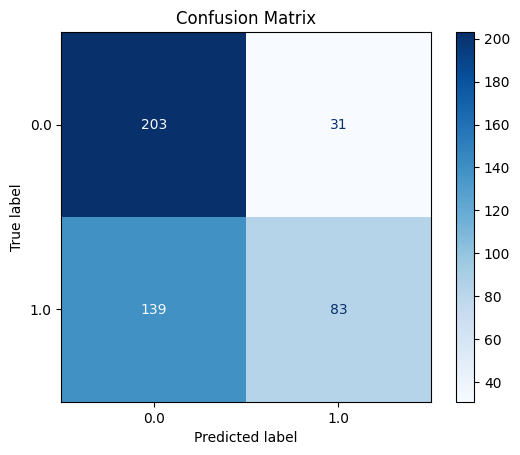

AUC: 0.6207


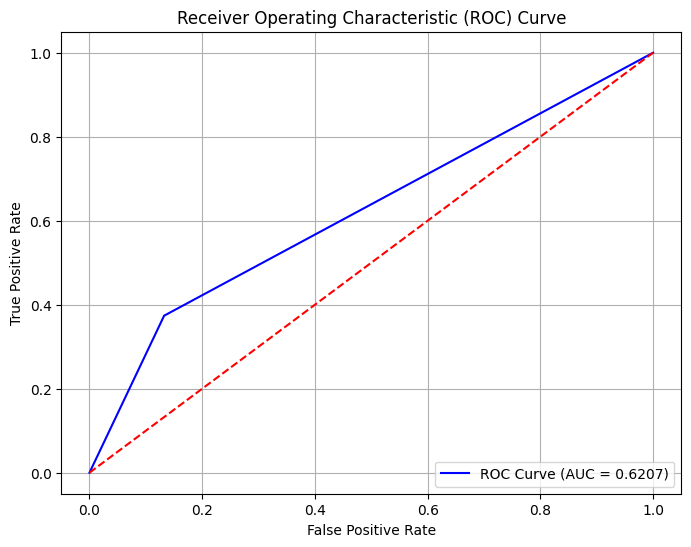

In [13]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

results, best_model = train_model_with_cross_validation(model, X_train, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test, y_test)
plot_roc_curve(best_model, X_test, y_test)

# SVM

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', C=1, probability=True)

results, best_model = train_model_with_cross_validation(model, X_train, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test, y_test)
plot_roc_curve(best_model, X_test, y_test)

# PCA

X_train shape (PCA): (1824, 71)
X_test shape (PCA): (456, 71)
y_train shape: (1824,)
y_test shape: (456,)


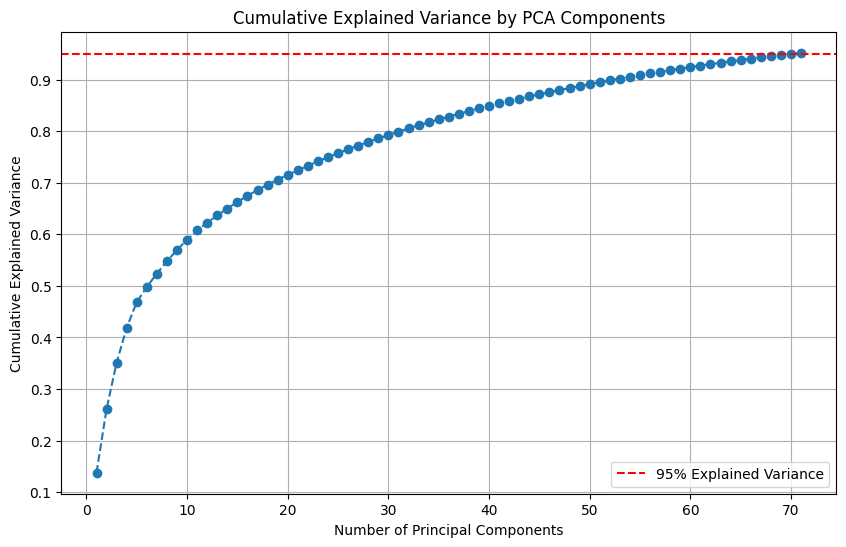

In [11]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Print the shapes of the splits after PCA
print(f"X_train shape (PCA): {X_train_pca.shape}")
print(f"X_test shape (PCA): {X_test_pca.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Plot explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.legend()
plt.show()

# Logistic Regression

Fold accuracy: 0.4438356164383562
Fold accuracy: 0.4547945205479452
Fold accuracy: 0.43561643835616437
Fold accuracy: 0.43561643835616437
Fold accuracy: 0.3956043956043956
{'accuracy': np.float64(0.43309348186060515), 'precision': np.float64(0.4353412163559902), 'recall': np.float64(0.4291636968401045), 'f1_score': np.float64(0.4318296639994753)}
Test Accuracy: 0.3772


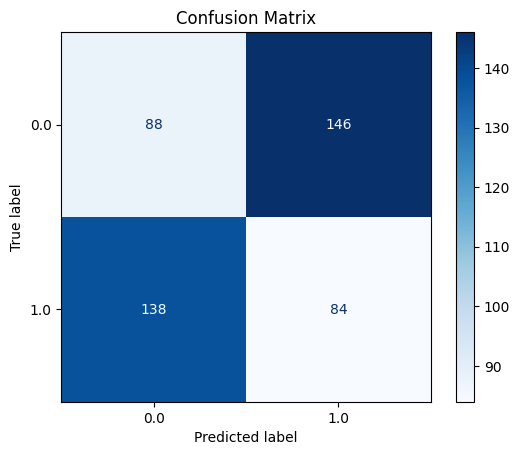

AUC: 0.3468


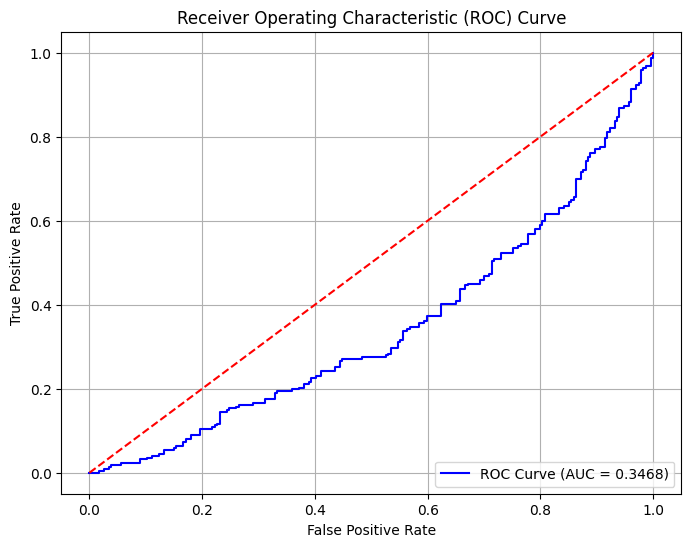

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000)
results, best_model = train_model_with_cross_validation(model, X_train_pca, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test_pca, y_test)
plot_roc_curve(best_model, X_test_pca, y_test)

# Random Forest

Fold accuracy: 0.6904109589041096
Fold accuracy: 0.6712328767123288
Fold accuracy: 0.7095890410958904
Fold accuracy: 0.6904109589041096
Fold accuracy: 0.7582417582417582
{'accuracy': np.float64(0.7039771187716394), 'precision': np.float64(0.805071952096797), 'recall': np.float64(0.5425576146353054), 'f1_score': np.float64(0.6479463777802864)}
Test Accuracy: 0.7039


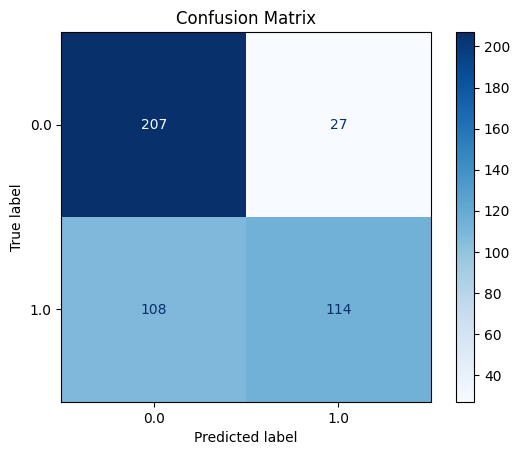

AUC: 0.8712


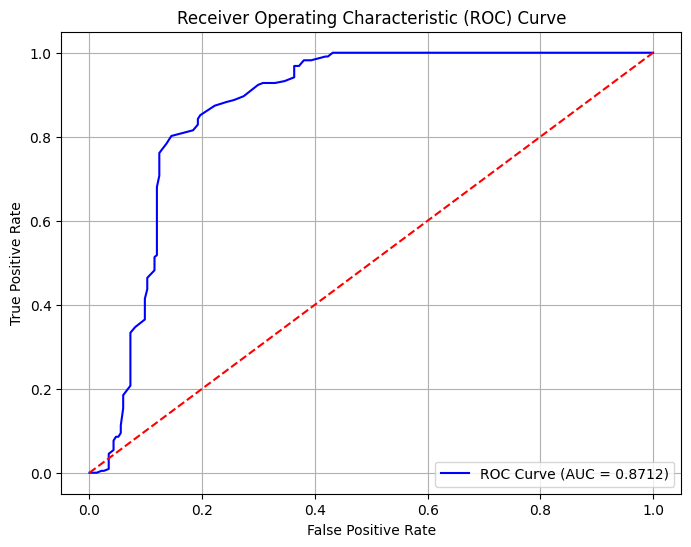

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

results, best_model = train_model_with_cross_validation(model, X_train_pca, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test_pca, y_test)
plot_roc_curve(best_model, X_test_pca, y_test)

# Decision Tree

Fold accuracy: 0.726027397260274
Fold accuracy: 0.7041095890410959
Fold accuracy: 0.7534246575342466
Fold accuracy: 0.7123287671232876
Fold accuracy: 0.739010989010989
{'accuracy': np.float64(0.7269802799939786), 'precision': np.float64(0.8257892740429504), 'recall': np.float64(0.5795141363744356), 'f1_score': np.float64(0.6809390882688519)}
Test Accuracy: 0.7566


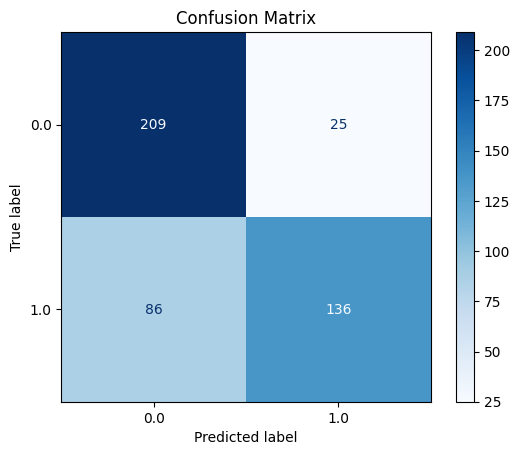

AUC: 0.7529


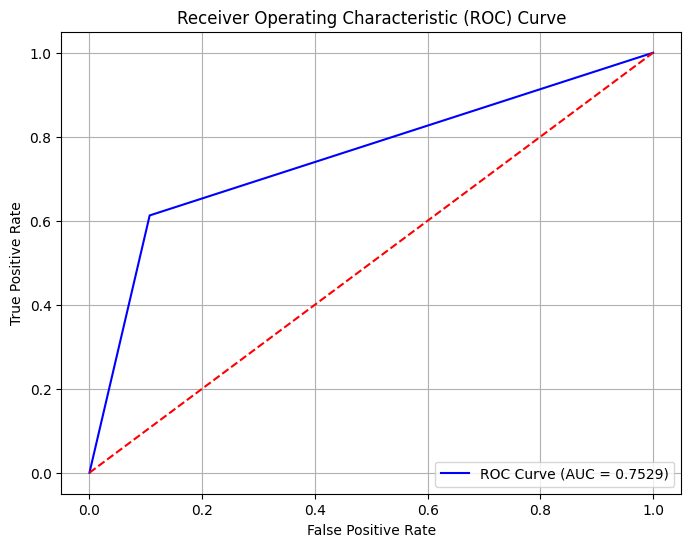

In [14]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

results, best_model = train_model_with_cross_validation(model, X_train_pca, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test_pca, y_test)
plot_roc_curve(best_model, X_test_pca, y_test)

# SVM

In [ ]:
# from sklearn.svm import SVC

# model = SVC(kernel='linear', C=1, probability=True)

# results, best_model = train_model_with_cross_validation(model, X_train_pca, y_train, n_splits=5)
# print(results)

# plot_confusion_matrix(best_model, X_test_pca, y_test)
# plot_roc_curve(best_model, X_test_pca, y_test)

# Neural Networks

In [11]:
import cv2
import numpy as np

# Resize function for a batch of images
def resize_images(images, target_size=(224, 224)):
    resized_images = np.array([cv2.resize(img, target_size) for img in images])
    return resized_images

# Resize your datasets
untampered_data_resized = resize_images(untampered_slices, target_size=(224, 224))
tampered_slices_resized = resize_images(tampered_slices, target_size=(224, 224))


In [12]:
# Convert grayscale to RGB
def ensure_rgb(images):
    return np.stack([images] * 3, axis=-1) if images.ndim == 3 else images

untampered_data_resized = ensure_rgb(untampered_data_resized)
tampered_slices_resized = ensure_rgb(tampered_slices_resized)


In [13]:
import numpy as np

# Combine data
all_data = np.concatenate((untampered_data_resized, tampered_slices_resized), axis=0)
all_labels = np.concatenate((untampered_labels, tampered_labels), axis=0)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

print(np.min(X_test), np.max(X_test))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


0 64796
(1824, 224, 224, 3)
(456, 224, 224, 3)
(1824,)
(456,)


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',           # Path to save the best model
    monitor='val_accuracy',             # Metric to monitor
    save_best_only=True,                # Save only the model with the best validation accuracy
    save_weights_only=False,            # Save the entire model (set to True for weights only)
    mode='max',                         # Maximize the monitored metric
    verbose=1                           # Print message when saving the model
)

X_train_neural = preprocess_input(X_train)  # Preprocess for VGG16
X_test_neural = preprocess_input(X_test)

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_neural, y_train, validation_data=(X_test_neural, y_test), epochs=50, batch_size=32, callbacks=[checkpoint_callback])
# history = model.fit(
#     train_generator,
#     validation_data=validation_generator,
#     epochs=20,
#     callbacks=[checkpoint_callback]
# )


2024-12-10 10:04:57.275860: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 10:04:57.447783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733853897.512167   41064 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733853897.529342   41064 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 10:04:57.685506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Freezing layer: input_layer
Freezing layer: block1_conv1
Freezing layer: block1_conv2
Freezing layer: block1_pool
Freezing layer: block2_conv1
Freezing layer: block2_conv2
Freezing layer: block2_pool
Freezing layer: block3_conv1
Freezing layer: block3_conv2
Freezing layer: block3_conv3
Freezing layer: block3_pool
Freezing layer: block4_conv1
Freezing layer: block4_conv2
Freezing layer: block4_conv3
Freezing layer: block4_pool
Freezing layer: block5_conv1
Freezing layer: block5_conv2
Freezing layer: block5_conv3
Freezing layer: block5_pool
Epoch 1/50


I0000 00:00:1733853903.235700   41240 service.cc:148] XLA service 0x7fba1c00d280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733853903.236209   41240 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-10 10:05:03.281528: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733853903.412479   41240 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/57 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4201 - loss: 5891.1514

I0000 00:00:1733853907.919941   41240 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4935 - loss: 2482.6208
Epoch 1: val_accuracy improved from -inf to 0.62719, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.4939 - loss: 2459.0232 - val_accuracy: 0.6272 - val_loss: 166.9533
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5721 - loss: 169.6568
Epoch 2: val_accuracy improved from 0.62719 to 0.63158, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5720 - loss: 169.1089 - val_accuracy: 0.6316 - val_loss: 61.8142
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6309 - loss: 72.2803
Epoch 3: val_accuracy improved from 0.63158 to 0.67544, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6310 - loss: 72.3159 - val_accuracy: 0.6754 - val_loss: 39.1537
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7003 - loss: 35.9581
Epoch 4: val_accuracy improved from 0.67

2024-12-10 10:05:26.781186: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7837 - loss: 14.1975
Epoch 6: val_accuracy improved from 0.77412 to 0.83114, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7837 - loss: 14.2318 - val_accuracy: 0.8311 - val_loss: 13.8125
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7780 - loss: 15.1464
Epoch 7: val_accuracy did not improve from 0.83114
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7776 - loss: 15.2093 - val_accuracy: 0.7610 - val_loss: 21.5758
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7809 - loss: 13.6458
Epoch 8: val_accuracy did not improve from 0.83114
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7807 - loss: 13.6640 - val_accuracy: 0.7675 - val_loss: 16.6591
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7847 - loss: 11.4439
Epoch 9: val_accuracy improved from 0.83114 to 0.83333, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58m

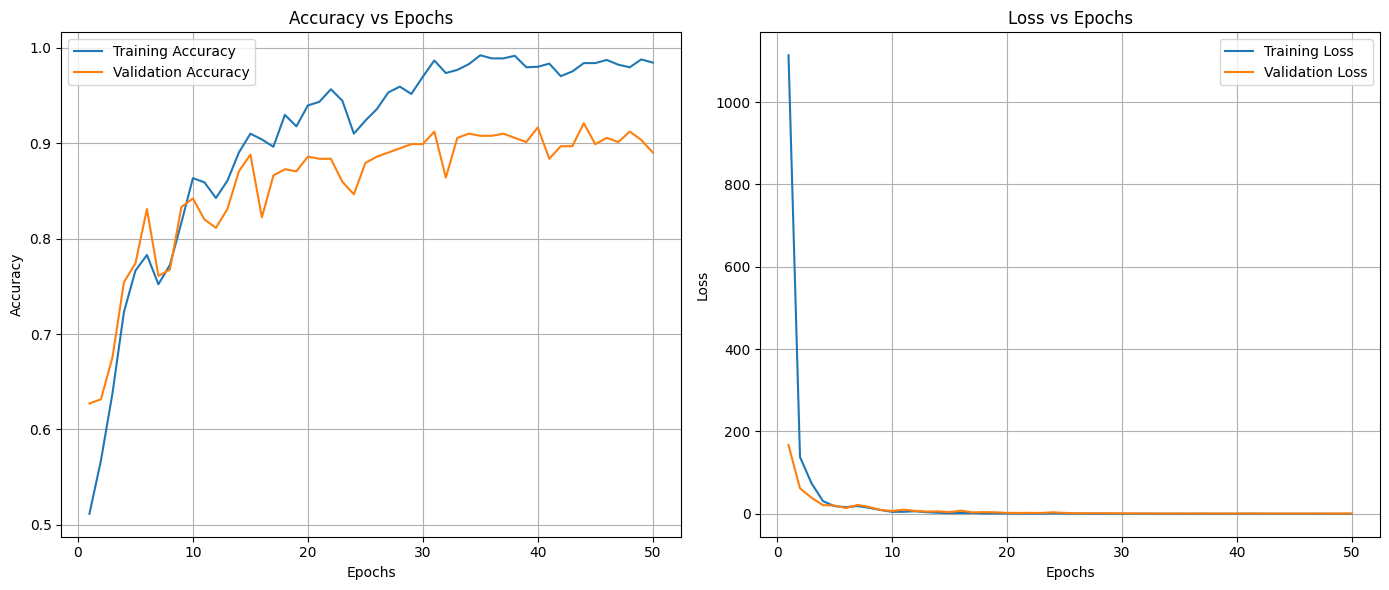

In [15]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract epoch range
epochs = range(1, len(train_accuracy) + 1)

# Create subplots for accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


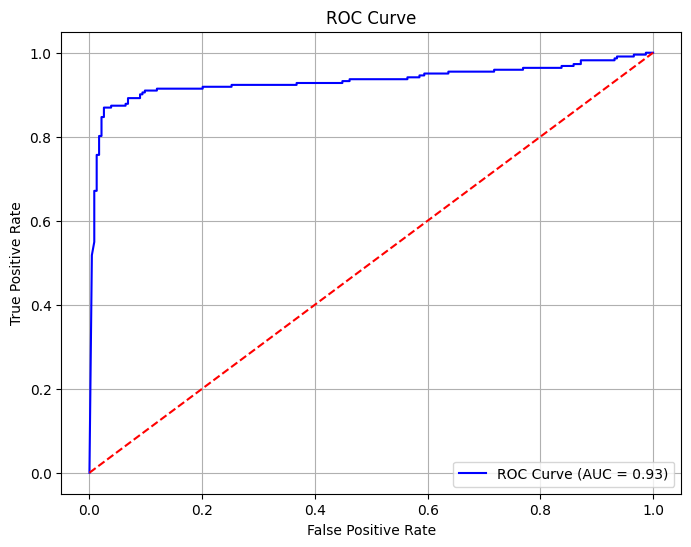

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('best_model.keras')
# Predict probabilities for the test set
y_pred_prob = model.predict(X_test_neural)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
0 255


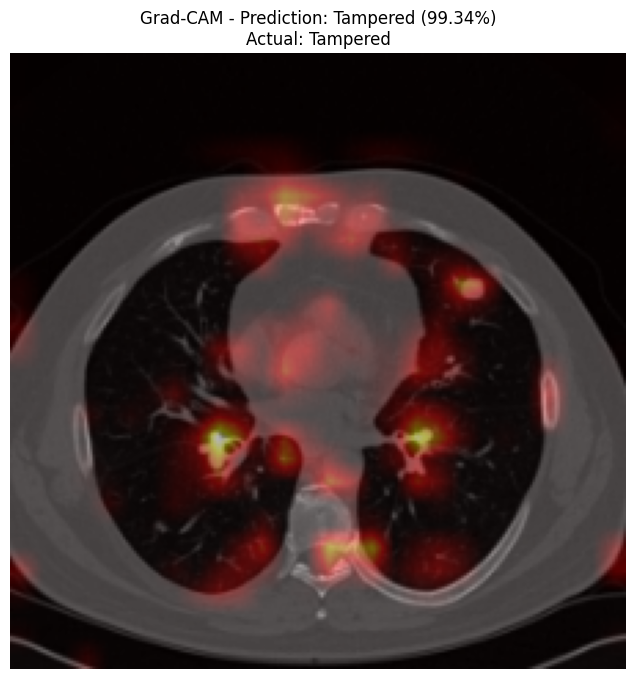

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0 255


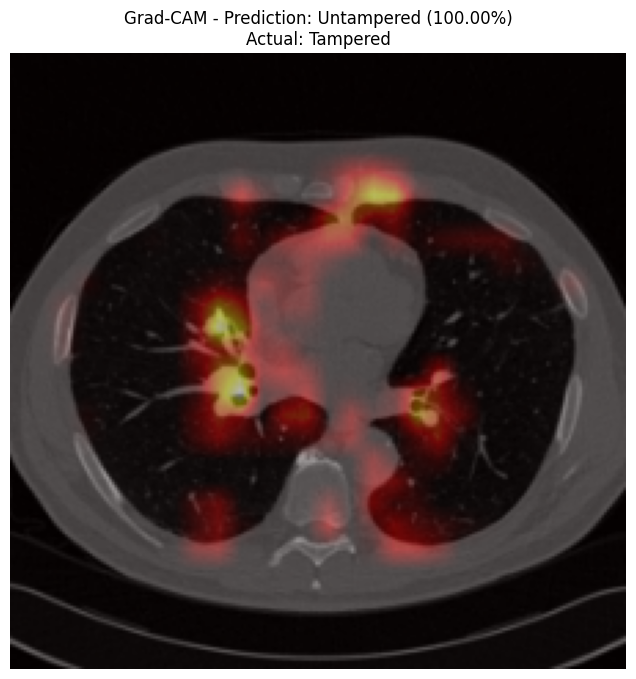

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0 255


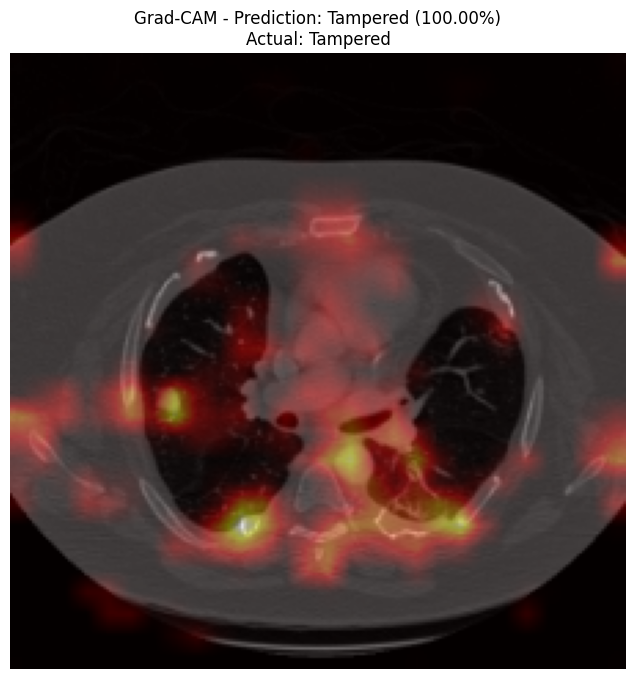

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
0 255


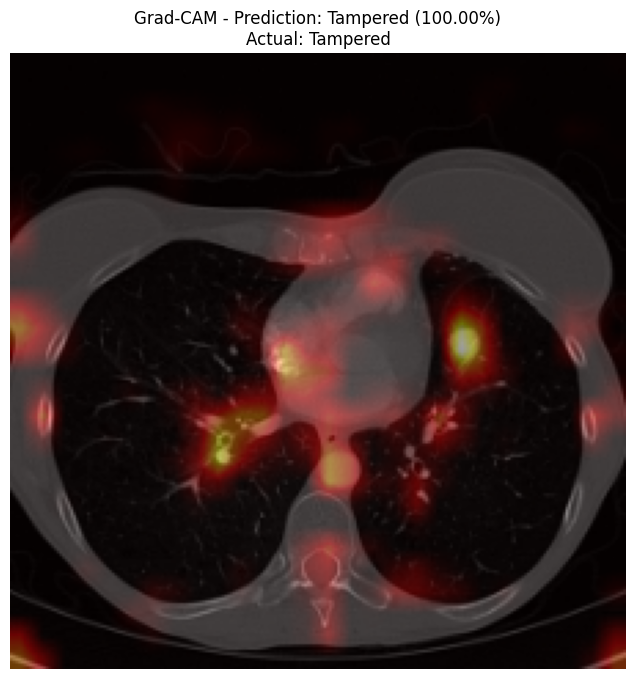

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0 255


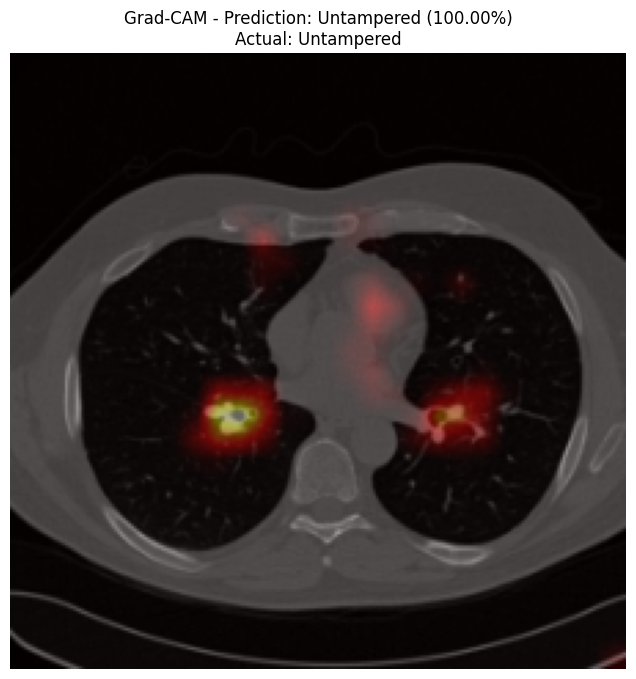

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0 255


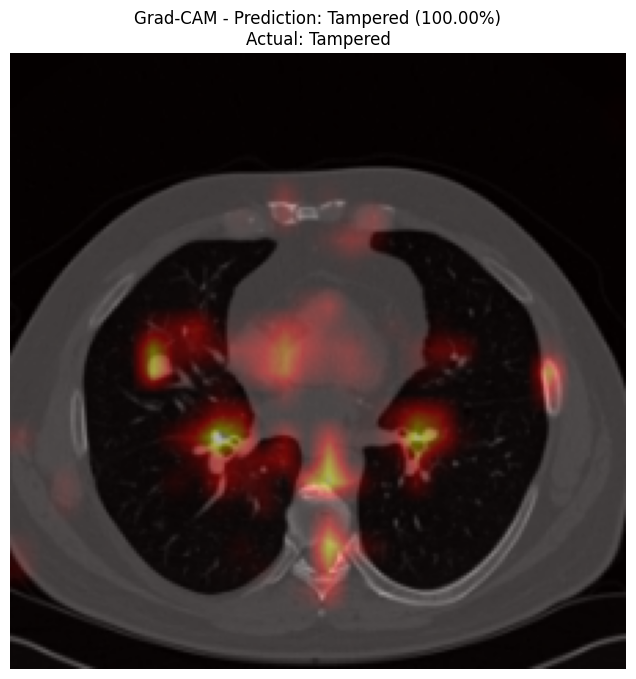

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0 255


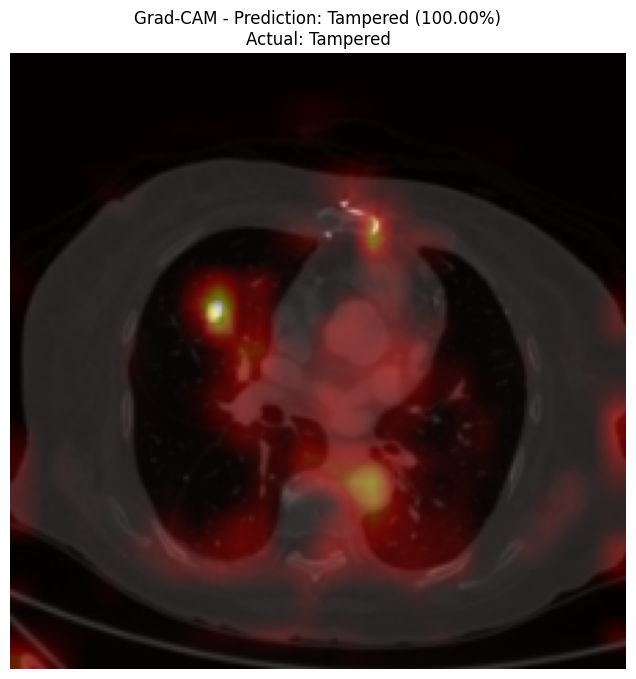

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0 255


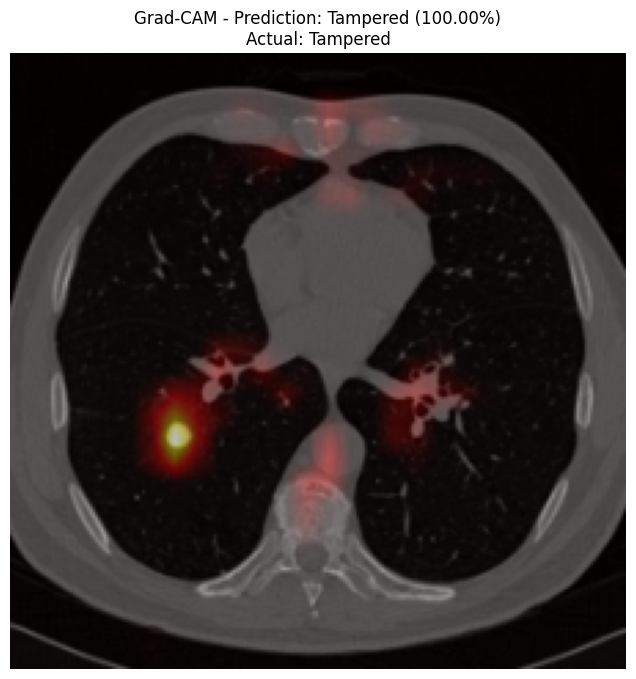

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0 255


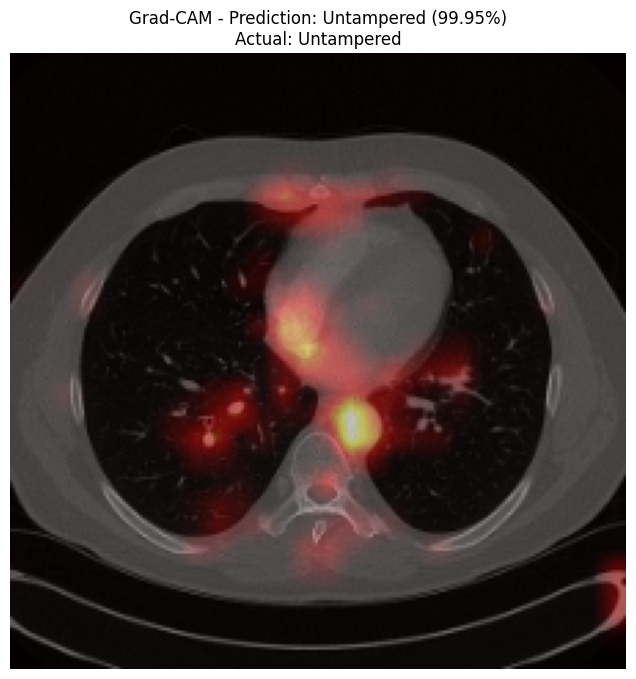

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0 255


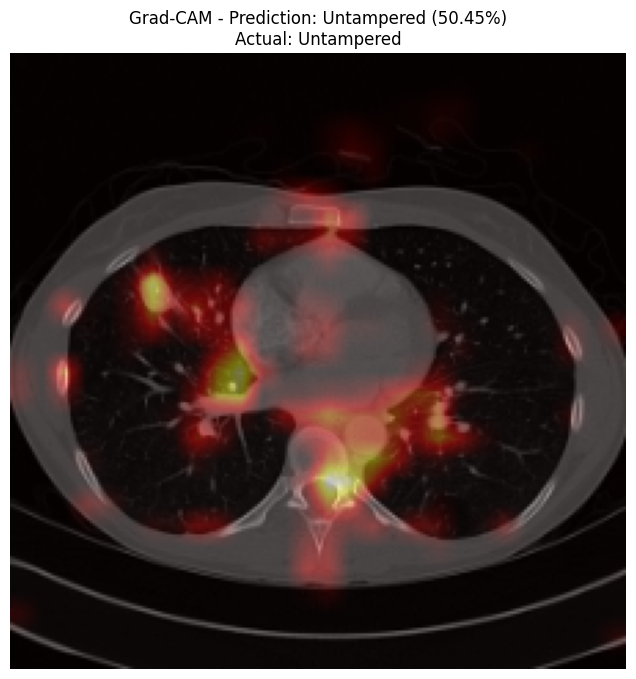

In [23]:
import cv2
from tensorflow.keras.models import Model
import tensorflow as tf

# Function to compute Grad-CAM
def compute_gradcam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.input, 
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients of the target class with respect to the output feature map
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature map by the gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU to focus on positive values
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()


model = load_model('best_model.keras')
for index in range(10):
    # Choose an image from the test set
    img_index = random.randint(0, len(X_test_neural) - 1)  # Index of the test image
    img = X_test_neural[img_index]
    img_array = np.expand_dims(img, axis=0)

    prediction = model.predict(img_array)
    predicted_class = "Tampered" if prediction[0] >= 0.5 else "Untampered"
    confidence = prediction[0][0] * 100 if prediction[0] >= 0.5 else (1 - prediction[0][0]) * 100

    actual_class = "Tampered" if y_test[img_index] == 1 else "Untampered"


    img -= np.min(img)
    if np.max(img) != 0:
        img /= np.max(img)
    img *= 255
    img = img.astype(np.uint8)

    img_array = np.expand_dims(img, axis=0)

    # Compute Grad-CAM heatmap
    last_conv_layer_name = "block4_conv1"  # Replace with your last convolutional layer's name
    heatmap = compute_gradcam(model, img_array, last_conv_layer_name)

    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Convert heatmap to a format suitable for visualization
    heatmap = np.uint8(255 * heatmap)
    

    # Overlay the heatmap on the original image
    print(np.min(img), np.max(img))
    original_image = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV if needed
    heatmap_color = plt.cm.hot(heatmap)  # Convert the heatmap to a color image with 'HOT' colormap
    heatmap_color = (heatmap_color[:, :, :3] * 255).astype(np.uint8)  # Remove alpha channel and scale to [0, 255]

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    # Display the image with Grad-CAM heatmap
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM - Prediction: {predicted_class} ({confidence:.2f}%)\nActual: {actual_class}')
    plt.axis('off')
    plt.show()
